## Importanto dependências

In [ ]:
from matplotlib import font_manager

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras import layers

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
import matplotlib as mpl

color = 'black' # change to black depending on your theme
mpl.rcParams['axes.labelcolor'] = color
mpl.rcParams['xtick.color'] = color
mpl.rcParams['ytick.color'] = color
mpl.rcParams['text.color'] = color

## Baixando datasets (Windows)

In [ ]:
!pip install -q kaggle

In [ ]:
!cp ~/Downloads/kaggle.json %HOME%/.kaggle/kaggle.json

In [ ]:
DATADIR="data"
![ ! -d "$DATADIR" ] && mkdir "$DATADIR"

!kaggle datasets download -d anokas/kuzushiji -p "$DATADIR" --unzip

## Instalando fontes e adicionando ao matplotlib (Windows)

In [ ]:
!echo %HOME%;

In [ ]:
system = platform.system()

if system == 'Windows':
    font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
    font_path = os.path.join(os.path.expanduser('~'), 'AppData\Local\Microsoft\Windows\Fonts\TakaoPGothic.ttf')
    font_manager.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'TakaoPGothic'
    
    # Check if the font is installed
    print(font_manager.findfont("TakaoPGothic"))
# !ls C:\\Users\\medin\\anaconda3\\envs\\vision\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf
elif system == 'Linux':
    pass

---
## Pré-processamento dos dados

### Carregando dados e separando conjuntos de treino e teste

In [13]:
# Loading data from compressed files
x_train = np.load('data\\k49-train-imgs.npz')['arr_0'].astype('float32')
x_test = np.load('data\\k-49-test-imgs.npz')['arr_0'].astype('float32')

# Normalize data between 0 and 1
x_train /= 255
x_test /= 255

# Adding one extra "channel" dimension
x_train_expanded = np.expand_dims(x_train, axis=-1)
x_test_expanded = np.expand_dims(x_test, axis=-1)

# Loading labels from compressed files
y_train_original = np.load('data\k49-train-labels.npz')['arr_0']
y_test_original = np.load('data\k49-test-labels.npz')['arr_0']

n_classes = len(np.unique(y_train_original))

# One hot encoding for cross entropy loss (for later when training the model)
y_train = np_utils.to_categorical(y_train_original, n_classes)
y_test = np_utils.to_categorical(y_test_original, n_classes)

In [14]:
print(f'Original training data shape: {x_train.shape} -  Expanded training data shape: {x_train_expanded.shape}')
print(f'Original testing data shape: {x_test.shape}   -  Expanded testing data shape: {x_test_expanded.shape}', end=f"\n{'---' * 15}\n")

print('Number of training samples: ', x_train.shape[0])
print('Number of testing samples: ', x_test.shape[0], end=f"\n{'---' * 15}\n")

print(f'Images resolution: {x_train.shape[1]}x{x_train.shape[2]}')
print('Number of classes: ', n_classes, end=f"\n{'---' * 15}\n")

Original training data shape: (232365, 28, 28) -  Expanded training data shape: (232365, 28, 28, 1)
Original testing data shape: (38547, 28, 28)   -  Expanded testing data shape: (38547, 28, 28, 1)
---------------------------------------------
Number of training samples:  232365
Number of testing samples:  38547
---------------------------------------------
Images resolution: 28x28
Number of classes:  49
---------------------------------------------


### Visualizando dados

In [15]:
# Loading classmap
df = pd.read_csv('data\k49_classmap.csv')
class_to_hiragana = df.to_dict(orient='index')

In [16]:
def get_hiragana(key):
  return class_to_hiragana[key]['char']

def visualize_random_hiraganas(x, y, n_cols=10, n_rows=5):
  n_imgs = n_cols * n_rows
  rand_idxs = np.random.randint(x.shape[0], size=n_imgs)

  rand_samples = x[rand_idxs]
  x = [get_hiragana(y[idx]) for idx in rand_idxs]

  fig = plt.figure(figsize=(n_cols, n_rows))
  plt.subplots_adjust(top=1)

  for i in range(n_imgs):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    ax.set_title(x[i])

    ax.tick_params(
      axis='both',
      which='both',
      labelleft=False,
      labelbottom=False,
      bottom=False,
      left=False
    )
    
    ax.imshow(rand_samples[i], cmap='gray')

  plt.savefig(f'plots/{n_imgs}_random_samples', transparent=True)
  plt.show()

def visualize_classes_inbalance(y, title=None):
  classes, frequencies = np.unique(y, return_counts=True)
  sorted_lists = sorted(zip(frequencies, classes))
  frequencies, classes = [list(pair) for pair in  zip(*sorted_lists)]

  hiraganas = [get_hiragana(class_) for class_ in classes]

  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(111)
  ax1.scatter(hiraganas, frequencies)

  title = title or 'classes_inbalance'
  plt.savefig(f'plots/{title}', transparent=True)
  plt.show()

def visualize_same_class_samples(x, y, n_classes=5, n_samples=5):
  n_rows = n_classes
  n_columns = n_samples

  np.random.seed()

  classes_range = np.unique(y) # 0 a 48
  rand_classes = np.random.randint(classes_range[0], classes_range[-1], size=n_rows)

  fig = plt.figure(figsize=(n_columns, n_rows), dpi=100)
  plt.subplots_adjust(top=1)
  
  n_imgs = n_rows + n_columns  
  i = 1
  while i <= n_imgs:
    for class_ in rand_classes:
      rand_class_idxs = np.where(y == class_)[0][:n_columns]
      for sample_idx in rand_class_idxs:
        ax = fig.add_subplot(n_rows, n_columns, i)
        ax.set_title(get_hiragana(class_))

        ax.tick_params(
          axis='both',
          which='both',
          labelleft=False,
          labelbottom=False,
          bottom=False,
          left=False
        )
        
        ax.imshow(x[sample_idx], cmap='gray')
        i += 1
        
  plt.savefig(f'plots/{n_rows}_classes_train_samples', transparent=True)
  plt.show()

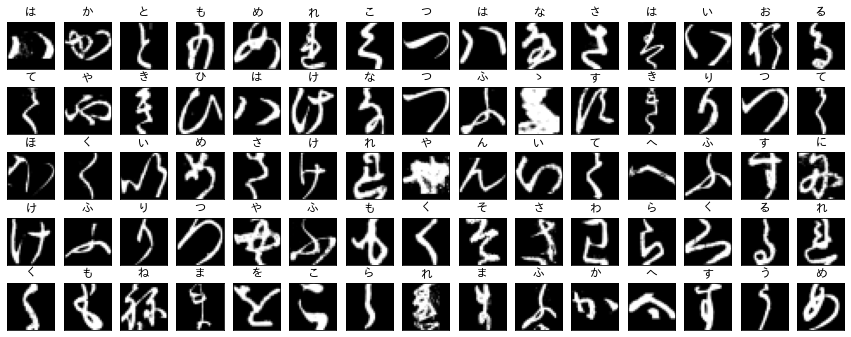

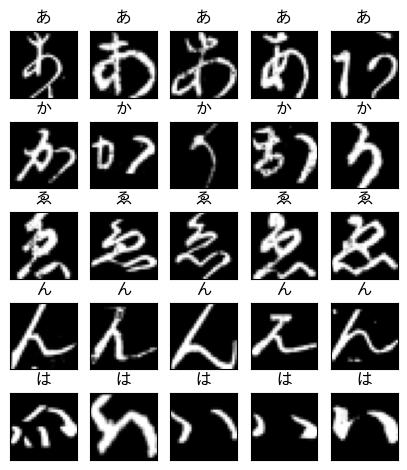

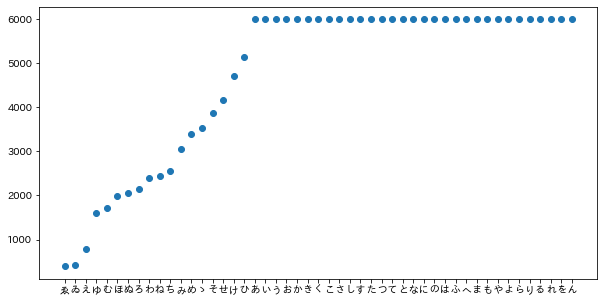

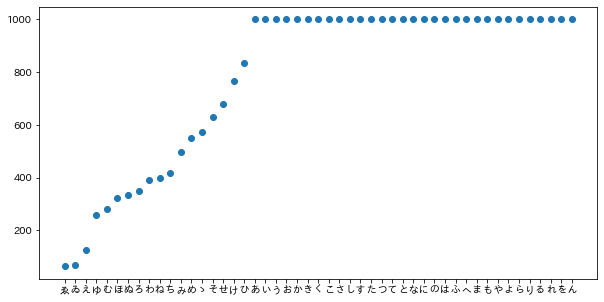

In [9]:
if not os.path.isdir('plots'):
    os.mkdir('plots')

visualize_random_hiraganas(x_train, y_train_original, n_cols=15)
visualize_same_class_samples(x_train, y_train_original)
visualize_classes_inbalance(y_train_original, title='classes_inbalance_train_samples')
visualize_classes_inbalance(y_test_original, title='classes_inbalance_test_samples')

---
## Treinamento

### Criando modelos
A ideia é treinar vários modelos com diferentes parâmetros (número de camadas, filtros, tamanho dos filtros, otimizadores, etc) e comparar a performance, através da acurácia e da análise da curva ROC obtidas pelos modelos treinados.

Foi criada uma função **build_network_model** para gerar modelos, dados os parâmetros necessários, estes são:
- name               - nome usado nomear o arquivo h5 que irá guardar os pesos treinados de cada modelo
- network_layers     - lista de camadas sequenciais do modelo (camadas do módulo layers do keras)
- compilation_params - dict com parâmetros da compilação do modelo (otimizador, função de custo, etc)
- show_summary       - flag que faz a função imprimir uma sumarização do modelo construído

In [17]:
def build_network_model(name, network_layers, compilation_params, show_summary=False):
    model = keras.Sequential(
        network_layers,
        name
    )
    
    model.compile(**compilation_params)
    
    if show_summary:
        model.summary()
    
    return model

### Modelos
Dois tipos de modelos foram usados: redes neurais (NN) e redes neurais convolucionais (CNNs). São criadas um total de 6 redes neurais e 6 redes neurais convolucionais.<br>
As 6 redes neurais são:
- NN_1_sgd
- NN_2_sgd
- NN_1_adam
- NN_2_adam
- NN_dense
- NN_dense_batch_form

E as 6 redes neurais convolucionais são:
- CNN_1_sgd
- CNN_2_sgd
- CNN_1_adam
- CNN_2_adam
- CNN_dense
- CNN_dense_batch_form

O objetivo das 4 primeiras redes, de cada tipo de modelo, é comparar o impacto na performance que diferentes otimizadores e diferentes quantidades de camadas (para NNs) ou filtros (para CNNs) faz.<br>
As duas últimas redes de cada tipo de modelo são redes mais custosas computacionalmente, com muito mais camadas ou filtros; sendo que metade delas usa [Batch Normalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) e a outra metade não. O objetivo é comparar se uma quantidade muito grande de camadas ou filtros, de fato melhora a performance consideravelmente, e se além disso, adicionar camadas de batch normalization ajuda.


In [18]:
neural_networks = [
    build_network_model(
        'NN_1_sgd',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_2_sgd',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=128, activation='relu', name='dense_2'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_1_adam',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_2_adam',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=128, activation='relu', name='dense_2'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_dense',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=128, activation='relu', name='dense_1'),
            layers.Dense(units=256, activation='relu', name='dense_2'),
            layers.Dense(units=512, activation='relu', name='dense_3'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_dense_batch_norm',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=128, activation='relu', name='dense_1'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=256, activation='relu', name='dense_2'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=512, activation='relu', name='dense_3'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    )
]

conv_neural_networks = [
    build_network_model(
        'CNN_1_adam',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_2_adam',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=128, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_1_sgd',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_2_sgd',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=128, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_dense',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=512, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),    
    build_network_model(
        'CNN_dense_batch_norm',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.BatchNormalization(axis=1),
            layers.Conv2D(filters=512, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.BatchNormalization(axis=1),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    )
]

## Treinamento
O treinamento consiste em fazer o fit de cada modelo no conjunto de treino, separando 30% desse conjunto para validação e usando batches com 128 samples. Após o treinamento são salvos os pesos para que o treinamento não precise ser executado novamente no futuro, mas apenas carregado (vide seção [Carregando Modelos](#carregando-modelos) abaixo).

In [19]:
def train_model(model, training_params, output_path='weights'):
    model.fit(**training_params)
    
    if not os.path.isdir(output_path):
        os.mkdir(output_path)
        
    model.save_weights(os.path.join(output_path, f'{model.name}.h5'))
    
    return model

def flatten(x):
    n_samples, width, height, _ = x.shape
    
    return np.reshape(x, (n_samples, width*height))

In [ ]:
train_model(conv_neural_networks[1], {'x': x_train_expanded, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3})

Epoch 1/10
2031/2542 [======================>.......] - ETA: 9:38 - loss: 0.6275 - accuracy: 0.8343

In [ ]:
train_model(conv_neural_networks[2], {'x': x_train_expanded, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3})

In [ ]:
train_model(conv_neural_networks[3], {'x': x_train_expanded, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3})

In [ ]:
train_model(conv_neural_networks[4], {'x': x_train_expanded, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3})

In [ ]:
train_model(conv_neural_networks[5], {'x': x_train_expanded, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3})

In [20]:
x_train_flattened = flatten(x_train_expanded)

nn_trained_models = [
    train_model(
        nn_model,
        {'x': x_train_flattened, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3}
    )
    for nn_model in neural_networks
]

cnn_trained_models = [
    train_model(
        cnn_model,
        {'x': x_train_expanded, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3}
    )
    for cnn_model in conv_neural_networks
]

Epoch 1/10
2542/2542 [==============================] - 9s 4ms/step - loss: 2.6380 - accuracy: 0.3724 - val_loss: 1.7881 - val_accuracy: 0.5557
Epoch 2/10
2542/2542 [==============================] - 8s 3ms/step - loss: 1.5755 - accuracy: 0.6093 - val_loss: 1.4643 - val_accuracy: 0.6342
Epoch 3/10
2542/2542 [==============================] - 8s 3ms/step - loss: 1.3448 - accuracy: 0.6628 - val_loss: 1.2780 - val_accuracy: 0.6770
Epoch 4/10
2542/2542 [==============================] - 8s 3ms/step - loss: 1.2086 - accuracy: 0.6952 - val_loss: 1.1681 - val_accuracy: 0.7057
Epoch 5/10
2542/2542 [==============================] - 8s 3ms/step - loss: 1.1110 - accuracy: 0.7195 - val_loss: 1.0890 - val_accuracy: 0.7244
Epoch 6/10
2542/2542 [==============================] - 9s 3ms/step - loss: 1.0373 - accuracy: 0.7369 - val_loss: 1.0290 - val_accuracy: 0.7379
Epoch 7/10
2542/2542 [==============================] - 8s 3ms/step - loss: 0.9783 - accuracy: 0.7513 - val_loss: 0.9798 - val_accuracy:

KeyboardInterrupt: 

## Avaliação

In [19]:
def evaluate_model(model, x_test, y_test, should_flatten=False):
    if should_flatten:
        x_test = flatten(x_test)
        
    loss, acc = model.evaluate(x_test, y_test, batch_size=128)
    print(f'loss: {loss:.2f} - accuracy: {acc * 100 :.2f}%')

In [ ]:
for model in neural_networks:
    evaluate_model(model, x_test_expanded, y_test, should_flatten=True)

for model in conv_neural_networks:
    evaluate_model(model, x_test_expanded, y_test)

# TODO Plotar curva ROC

# TODO Arrumar plots

In [9]:
def generate_random_index(x):
    while True:
        yield np.random.randint(0, x.shape[0], size=1)[0]

def show_random_predictions(trained_models, n_predictions, x_test):
    n_rows = len(trained_models)
    n_cols = n_predictions
    
    fig, big_axes = plt.subplots(figsize=(15, 15), ncols=1, nrows=n_rows, sharey=True)

    for row, big_ax in enumerate(big_axes, start=1):
        big_ax.set_title(trained_models[row-1].name, fontsize=16)

        # Turn off axis lines and ticks of the big subplot 
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        
        # removes the white frame
        big_ax._frameon = False
        
    idx_generator = generate_random_index(x_test)
#     fig = plt.figure(figsize=(n_cols, n_rows), dpi=150)
    
    i = 1
    while i <= n_predictions:
        idx = next(idx_generator)
        
        for pos, model in enumerate(trained_models[-1:]):
            probabilities = model.predict(x_test[idx:idx+1])

            predicted_class = get_hiragana(np.argmax(probabilities))
            real_class      = get_hiragana(np.argmax(y_test[0]))
            
            # Add to subplot
            ax = fig.add_subplot(n_rows, n_cols, i + n_cols*pos)
            ax.set_title(f'predicted class:  {predicted_class}\nreal_class: {real_class}')
            
            ax.tick_params(
              axis='both',
              which='both',
              labelleft=False,
              labelbottom=False,
              bottom=False,
              left=False
            )
            
            ax.imshow(x_test[idx], cmap='gray')
            
        i += 1
        
    fig.set_facecolor('w')
    plt.tight_layout()
    plt.savefig('testes.jpg')
    plt.show()

In [ ]:
show_random_predictions(nn_trained_models + cnn_trained_models, 5, x_test_expanded)
# x_test_flattened = flatten(x_test_expanded)

# show_random_predictions(trained_models[0], x_test_flattened, y_test, x_test)
# show_random_predictions(trained_models[5], x_test_expanded, y_test, x_test)

---
### Carregando modelos

In [ ]:
def load_model(models, model_name):
    model = list(filter(lambda x: x.name == model_name, models))[0]
    model.load_weights(f'weights/{model_name}.h5')
    
    return model

weights_filenames = os.listdir('weights')

nn_trained_models = [load_model(neural_networks, filename[:-3]) for filename in weights_filenames if filename.startswith('NN')]
cnn_trained_models = [load_model(conv_neural_networks, filename[:-3]) for filename in weights_filenames if filename.startswith('CNN')]

print(nn_trained_models, cnn_trained_models, sep='\n\n')